### Carregamento das bibliotecas

In [1]:
# Manipulacao de dados
import numpy as np
import pandas as pd

# Visualizacao de dados
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scikitplot as skplt

# Machine learning 
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# cross validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate, KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Selecao de caracteristicas e encoders
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Metricas de avaliacao
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, average_precision_score,plot_roc_curve

# remover warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("files/covid_2021_cleaned.csv", sep=';')

In [3]:
df.head()

,SEXO,FAIXAETARIA,EVOLUCAO,FEBRE,TOSSE,GARGANTA,DISPNEIA,GESTANTE,SRAG,CARDIOPATIA,DIABETES,DOENCA_RESPIRATORIA,PROBLEMA_RENAL,OBESIDADE,DOENCA_CROMOSSOMICA
0,Masculino,50 a 59,0,NAO,NAO,NAO,NAO,NAO,NAO,NAO,NAO,NAO,NÃO,NAO,NAO
1,Masculino,<1,0,SIM,NAO,NAO,NAO,NAO,NAO,NAO,NAO,NAO,NÃO,NAO,NAO
2,Masculino,30 a 39,0,NAO,SIM,SIM,NAO,NAO,NAO,NAO,NAO,NAO,NÃO,NAO,NAO
3,Masculino,20 a 29,0,NAO,SIM,NAO,SIM,NAO,NAO,NAO,NAO,NAO,NÃO,NAO,NAO
4,Feminino,50 a 59,0,NAO,SIM,NAO,SIM,NAO,SIM,NAO,NAO,NAO,NÃO,NAO,NAO


___
# III. Teste e validação dos modelos

## 1.  *Feature Encoding*

Como modelos de *machine learning* performam algebra linear em matrizes, precisamos que todas as variáveis estejam como valores numericos. O processo de conversão de variaveis categoricas em numéricas é chamado de *Encoding*. Existem algumas abordagens para converter os dados categóricos em numéricos, para que o modelo possa entendê-los. Veremos os dois métodos: **Label encoding** e **One-Hot encoding**.

- Label Encoding: Recomendado quando lidamos com variáveis categóricas ordinais: Consiste em *designar um valor inteiro* (0, 1, 2, ...) oara cada valor unico da coluna.
- One-hot encoding: Consiste em *criar uma nova coluna* para cada valor único de uma coluna existente.

Material complementar:
- [Um guia (simples) de como tratar variáveis categóricas em Machine Learning](https://medium.com/@nelson.ewert.oliveira/um-guia-simples-de-como-tratar-vari%C3%A1veis-categ%C3%B3ricas-em-machine-learning-b791a00da805)
- [One-Hot Encoding vs. Label Encoding using Scikit-Learn](https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/)
- [Guide to Encoding Categorical Values in Python](https://pbpython.com/categorical-encoding.html)

Para nosso contexto, vamos utilizar o **One-hot encoding**.


In [4]:
df = pd.get_dummies(df, drop_first=True)

In [5]:
df.columns

Index(['EVOLUCAO', 'SEXO_Masculino', 'FAIXAETARIA_05 a 09',
       'FAIXAETARIA_10 a 14', 'FAIXAETARIA_15 a 19', 'FAIXAETARIA_20 a 29',
       'FAIXAETARIA_30 a 39', 'FAIXAETARIA_40 a 49', 'FAIXAETARIA_50 a 59',
       'FAIXAETARIA_60 a 69', 'FAIXAETARIA_70 a 79', 'FAIXAETARIA_80 e mais',
       'FAIXAETARIA_<1', 'FEBRE_SIM', 'TOSSE_SIM', 'GARGANTA_SIM',
       'DISPNEIA_SIM', 'GESTANTE_SIM', 'SRAG_SIM', 'CARDIOPATIA_SIM',
       'DIABETES_SIM', 'DOENCA_RESPIRATORIA_SIM', 'PROBLEMA_RENAL_SIM',
       'OBESIDADE_SIM', 'DOENCA_CROMOSSOMICA_SIM'],
      dtype='object')

In [6]:
# renomear para nao dar problema com '<'
df.rename(columns={"FAIXAETARIA_<1": "FAIXAETARIA_MENOR_1"}, inplace=True)

In [7]:
df.columns

Index(['EVOLUCAO', 'SEXO_Masculino', 'FAIXAETARIA_05 a 09',
       'FAIXAETARIA_10 a 14', 'FAIXAETARIA_15 a 19', 'FAIXAETARIA_20 a 29',
       'FAIXAETARIA_30 a 39', 'FAIXAETARIA_40 a 49', 'FAIXAETARIA_50 a 59',
       'FAIXAETARIA_60 a 69', 'FAIXAETARIA_70 a 79', 'FAIXAETARIA_80 e mais',
       'FAIXAETARIA_MENOR_1', 'FEBRE_SIM', 'TOSSE_SIM', 'GARGANTA_SIM',
       'DISPNEIA_SIM', 'GESTANTE_SIM', 'SRAG_SIM', 'CARDIOPATIA_SIM',
       'DIABETES_SIM', 'DOENCA_RESPIRATORIA_SIM', 'PROBLEMA_RENAL_SIM',
       'OBESIDADE_SIM', 'DOENCA_CROMOSSOMICA_SIM'],
      dtype='object')

In [8]:
# salvar no disco
df.to_csv("files/covid_2021_prepared.csv", sep=';', index=False)

## 2. Separação treino-teste

In [9]:
X = df.drop(['EVOLUCAO'], axis=1)
y = df['EVOLUCAO']

In [10]:
# divisao treino test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=777)

## 3. Treino dos modelos

Material complementar:
- [How To Choose The Right Test Options When Evaluating Machine Learning Algorithms](https://machinelearningmastery.com/how-to-choose-the-right-test-options-when-evaluating-machine-learning-algorithms/)
- [Why you should be Spot-Checking Algorithms on your Machine Learning Problems](https://machinelearningmastery.com/why-you-should-be-spot-checking-algorithms-on-your-machine-learning-problems/)
- [A Data-Driven Approach to Choosing Machine Learning Algorithms](https://machinelearningmastery.com/a-data-driven-approach-to-machine-learning/)
- [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)

In [11]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

Árvore de decisão
ROC-AUC SCORE: 0.7089945660439164
PRECISION: 0.5623236124176858
RECALL: 0.42895586652314316
Floresta aleatória
ROC-AUC SCORE: 0.7122840823993379
PRECISION: 0.5647825075598977
RECALL: 0.43559382848941514
XGBoost
[19:28:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC SCORE: 0.7113569472818817
PRECISION: 0.5825688073394495
RECALL: 0.43290276282741297


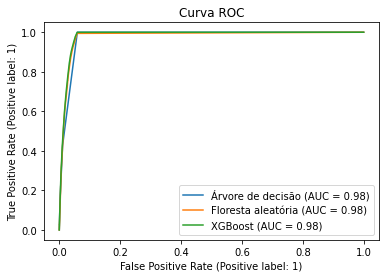

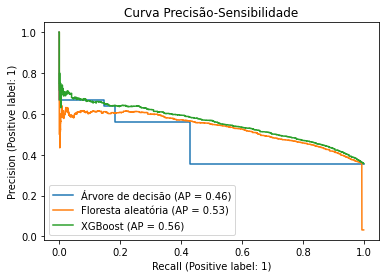

In [14]:
SEED = 777
np.random.seed(SEED)
models = [DecisionTreeClassifier(max_depth=3, random_state=SEED), RandomForestClassifier(random_state=SEED), XGBClassifier(random_state=SEED)]

verbose_models = ['Árvore de decisão', 'Floresta aleatória', 'XGBoost']

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

model_displays = {}
for name, model in zip(verbose_models, models):
    print("===============")
    print(name)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"ROC-AUC SCORE: {roc_auc_score(y_test, y_pred)}")
    print(f"PRECISION: {precision_score(y_test, y_pred)}")
    print(f"RECALL: {recall_score(y_test, y_pred)}")
    model_displays[name] = plot_roc_curve(model, X_test, y_test, ax=ax1, name=name)
    plot_precision_recall_curve(model, X_test, y_test, ax=ax2, name=name)
    print("===============")

_ = ax1.set_title('Curva ROC')
_ = ax2.set_title('Curva Precisão-Sensibilidade')
plt.show()     

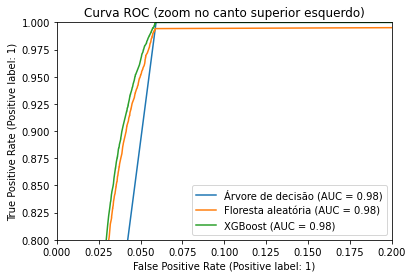

In [13]:
fig, ax = plt.subplots()
for name, model in zip(verbose_models, models):
    model_displays[name].plot(ax=ax)

ax.set_xlim(0, 0.2)
ax.set_ylim(0.8, 1)
_ = ax.set_title('Curva ROC (zoom no canto superior esquerdo)')